# Feature importance in predicting a negative NPS response


## import packages


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap
from pathlib import Path
import matplotlib.pyplot as plt


## Load / Transform NPS data 

In [2]:
nps = pd.read_csv('../../Desktop/nps_file.csv').drop(columns=['Feedback Id', 'Order Gmv'])

nps.columns = nps.columns.str.replace(' ', '')


nps.head(2)

,LeftDetractorResponse,SingleSuborder,OrderType,OrderIsWl,OrderIsUser,OrderIsGift,OrderIsEgiftRedemption,GifterStatus,UserStatus
0,True,True,New Platform,False,guest,self,False,never_gifter,blend_user
1,False,True,New Platform,False,guest,self,False,never_gifter,never_user


  ### Convert dtypes

In [3]:

# Convert the categorical columns to category data type

categorical_columns = ['OrderType',
                     'OrderIsUser',
                     'OrderIsGift',
                     'GifterStatus',
                     'UserStatus'
]

for col in categorical_columns:
    nps[col] = nps[col].astype("category")


# Convert the boolean columns to bool data type    
bool_columns = ['LeftDetractorResponse',
                'SingleSuborder',
                'OrderIsWl',
                'OrderIsEgiftRedemption',
                
]

for col in bool_columns:
    nps[col] = nps[col].astype('bool')



## Split data

In [4]:

X = nps.drop(columns='LeftDetractorResponse')
y = nps.LeftDetractorResponse

X_train, X_test, y_train,y_test = train_test_split(X,y,test_size = 0.2, stratify = y, random_state = 8)



[nps.shape for nps in (X_train, X_test, y_train, y_test)]

[(9324, 8), (2332, 8), (9324,), (2332,)]

### Not sure what this next step is doing
#### copied from a tutorial on training xgboost model

In [5]:
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier

estimators = [
    ('encoder',TargetEncoder()),
    ('clf',XGBClassifier(random_state=8))
]

pipe = Pipeline(steps=estimators)

## Train XGBoost model

#### I copied this code from our hackathon, and I am not sure what each step is doing

In [6]:
# Specify the model hyperparameters
params={ 'objective': 'binary:logistic',
        "eval_metric": "auc", #"logloss",
        "tree_method": 'hist',
        "n_estimators": 100,
        "max_depth": 5,
        "early_stopping_rounds": 10,
        "verbosity": 1
       }

In [7]:
clf = xgb.XGBClassifier(**params, enable_categorical=True)
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
# clf.save_model(Path(saved_models_path, f"xgboost_categorical_model_{current_time}.json"))

[0]	validation_0-auc:0.56684
[1]	validation_0-auc:0.56789
[2]	validation_0-auc:0.56872
[3]	validation_0-auc:0.56756
[4]	validation_0-auc:0.56514
[5]	validation_0-auc:0.56476
[6]	validation_0-auc:0.56601
[7]	validation_0-auc:0.56618
[8]	validation_0-auc:0.56617
[9]	validation_0-auc:0.56662
[10]	validation_0-auc:0.56738
[11]	validation_0-auc:0.56728
[12]	validation_0-auc:0.56649


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=True, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [8]:
clf.feature_importances_

array([0.14575851, 0.05007454, 0.10451145, 0.04918329, 0.05833285,
       0.        , 0.47795406, 0.11418525], dtype=float32)

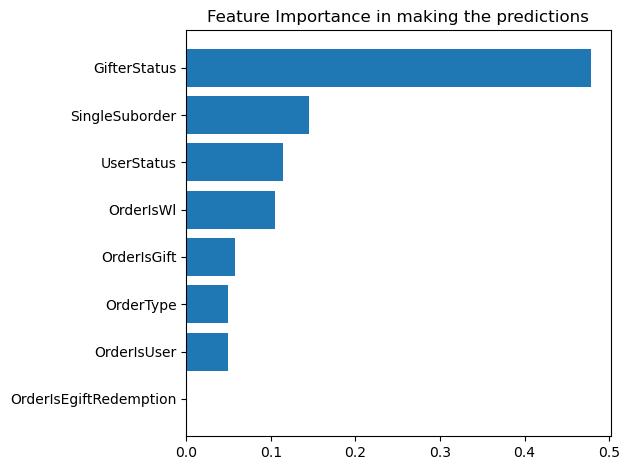

In [9]:
sorted_idx = clf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.title("Feature Importance in making the predictions")
plt.tight_layout()

In [11]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(clf)
# shap_values = explainer(X)
shap_values = explainer(X_test)

# visualize the first observation prediction's explanation
shap.plots.waterfall(shap_values[0], max_display=20, show=False) 


<Axes: >

In [12]:
shap_values

.values =
array([[-0.05875557,  0.00815943,  0.00080633, ...,  0.        ,
         0.10571763,  0.0309956 ],
       [-0.05875557,  0.00815943,  0.00080633, ...,  0.        ,
         0.10571763,  0.0309956 ],
       [-0.03876486, -0.00247111,  0.00080633, ...,  0.        ,
         0.10465976,  0.03184627],
       ...,
       [-0.05875557,  0.00815943,  0.00080633, ...,  0.        ,
         0.10571763,  0.0309956 ],
       [-0.05875557,  0.00815943,  0.00080633, ...,  0.        ,
         0.10571763,  0.0309956 ],
       [-0.05789849,  0.02381765,  0.00031135, ...,  0.        ,
        -0.22764565,  0.05090386]], dtype=float32)

.base_values =
array([-1.5211643, -1.5211643, -1.5211643, ..., -1.5211643, -1.5211643,
       -1.5211643], dtype=float32)

.data =
array([[True, 'New Platform', False, ..., False, 'never_gifter',
        'only_user'],
       [True, 'New Platform', False, ..., False, 'never_gifter',
        'only_user'],
       [True, 'New Platform', False, ..., False, 'never_

In [13]:
shap.summary_plot(shap_values, X_test, show=False) 

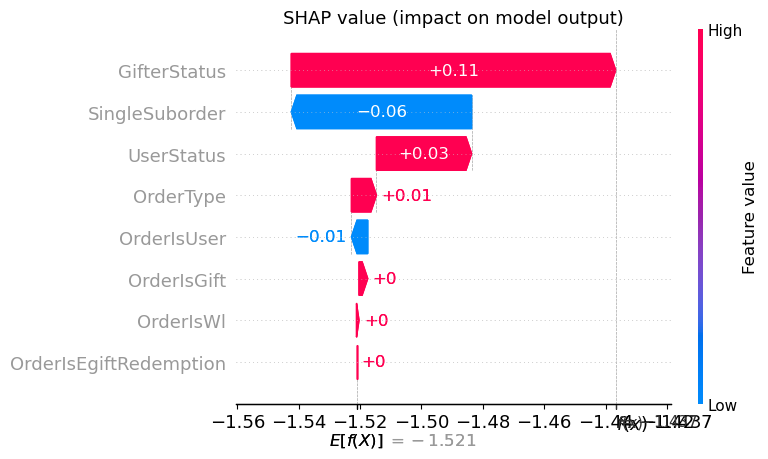

In [14]:
plt.show()


In [10]:




# should I avoid importing packages outside of a virtual env 
# estimator/pipe step 
# hyperparameter tuning? 